In [ ]:
# Copyright 2023 Regeneron Pharmaceuticals Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Example of calculating and plotting feature importances

Here we show a small example of the application of random forest (RF) models on the TCR-VALID latent representations to classify and regress against known generative factors: V usage, J usage, and non-germline CDR3 sequence mean physical features.

Here, we use one set of hyperparameters for the random forests for the sake of speed, though in the manuscript we use a cross-validation scheme first to select the optimal hyperparameters for eahc model. 

In [1]:
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

from tcrvalid.load_models import *
from tcrvalid.plot_utils import set_simple_rc_params
from tcrvalid.physio_embedding import SeqArrayDictConverter
from tcrvalid.data_subsetting import *
from tcrvalid.defaults import *

from hinton import hinton

(21, 7)
(22, 8)


#### Define functions

 - entanglement()
     - calculate importance of each latent dimension for each of the three generative factors
     
 - build_Physio_Features()
     - Collect mean physical features in the 'insert' region (not coded by J or J)
     
 - hinton()
     - draw the hinton diagram
     - taken from matplotlib - see function docstring for copyright and license information

In [2]:
def entanglement(reps_forRF,df_forRF,seed):  
    rfC = RandomForestClassifier()
    rfR = RandomForestRegressor()
    imps=dict()
    for feat in ['v_call','j_call']:
        rfC = RandomForestClassifier(random_state=seed,n_estimators=200,class_weight='balanced', max_depth=None)
        pepd = {p:i for i,p in enumerate(df_forRF[feat].unique())}
        rfC.fit(reps_forRF,df_forRF[feat].map(pepd).values)
        imps[feat] = rfC.feature_importances_

    for feat in ['Mean_Physio']:
        rfR = RandomForestRegressor(random_state=seed,n_estimators=200, max_depth=None)
        rfR.fit(reps_forRF,df_forRF[feat])
        imps[feat] = rfR.feature_importances_

    return imps

def build_Physio_Features(insert_codons_aa):
    if len(insert_codons_aa)>0:
        try:
            prefeatures_forRF = mapping.seqs_to_array([insert_codons_aa],maxlen=None)
            features_forRF = prefeatures_forRF[0,:,:].mean(axis=0)[:7]
            return features_forRF
        except:
            return None
    else:
        return None

In [3]:
np.random.seed(19680801)

#### Collect data and TCR-VALID model

In [4]:
mapping = SeqArrayDictConverter()
loaded_models_TRB = load_named_models('1_2',chain='TRB', encoders=True)
trb_test_pq = data_path_small_trb['te']
te_seq_trb_df = pd.read_parquet(trb_test_pq, columns=['cdr2_cdr3','new_meta_vcall','j_call','insert_codons_aa']).head(100000)

2023-05-05 15:00:29.017203: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-05 15:00:29.017257: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gen-queue-dy-m516xlarge-17): /proc/driver/nvidia/version does not exist
2023-05-05 15:00:29.018353: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Collect mean physiochemical properties of non-germline region

In [5]:
te_seq_trb_df['Physio_Feats'] = te_seq_trb_df.insert_codons_aa.map(lambda x: build_Physio_Features(x))
te_seq_trb_df['Mean_Physio'] = te_seq_trb_df['Physio_Feats'].map(lambda x: np.mean(x),na_action='ignore')
te_seq_trb_df = te_seq_trb_df.rename(columns={"new_meta_vcall": "v_call"})
te_seq_trb_df = te_seq_trb_df[~te_seq_trb_df['Mean_Physio'].isna()]

#### Project TCR sequences to physicochemical properties and then TCR-VALID representations

In [6]:
x_tr = mapping.seqs_to_array(list(te_seq_trb_df.cdr2_cdr3.values),maxlen=28)
z_mean_dfs, z_log, z_samp_dfs = loaded_models_TRB['1_2'].predict(x_tr)

#### Get the feature importances of each dimension for each generative factor

In [7]:
imps = entanglement(z_samp_dfs,te_seq_trb_df,42)

#### Create and plot the Hinton diagram for this particular model

In [8]:
Hinton_arr = np.array([imps['Mean_Physio'],imps['v_call'],imps['j_call']])

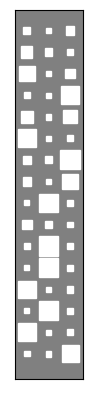

In [9]:
hinton(Hinton_arr)
plt.show()